# Time series with seasonality

In this notebook, we'll take a look at some examples of time series with a clear seasonality.

I used data from the [time series data library](https://datamarket.com/data/list/?q=provider%3Atsdl) on Datamarket.

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from helper import test_stationarity

%matplotlib inline

In [19]:
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [15,10]
plt.rcParams['font.size'] = 22

## Data set

I found this data set interesting in the time series library. It is made of 240 observations from 1920 to 1939. The values are monthly temperatures (Farenheit degrees) collected in the city of Nottingham. More details [here](https://datamarket.com/data/set/22li/mean-monthly-air-temperature-deg-f-nottingham-castle-1920-1939#!ds=22li&display=line).

In [20]:
mean_monthly_temp = pd.read_csv('../data/mean-monthly-air-temperature-deg.csv', 
                              index_col=0,
                              parse_dates=True,
                              names=['Date', 'Temperature'],
                              header=0,
                              skipfooter=2, 
                              engine='python')
mean_monthly_temp.head()

,Temperature
Date,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


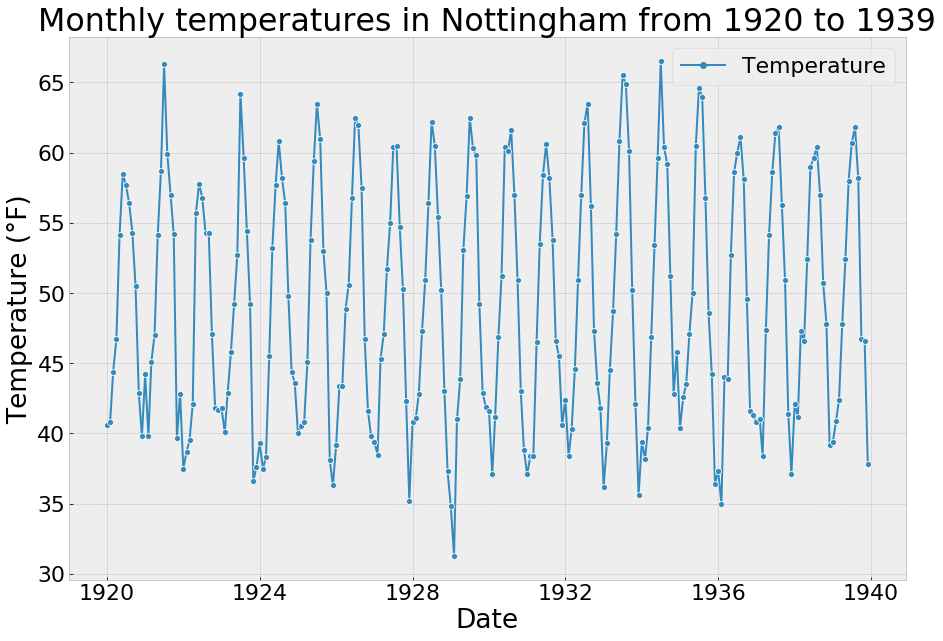

In [21]:
plt.ylabel('Temperature (°F)')
plt.xlabel('Time')
plt.title('Monthly temperatures in Nottingham from 1920 to 1939')
sns.lineplot(data = mean_monthly_temp, markers = True)

We immediately see the strong seasonality. Let's have a look at two or three years to zoom in a little bit.

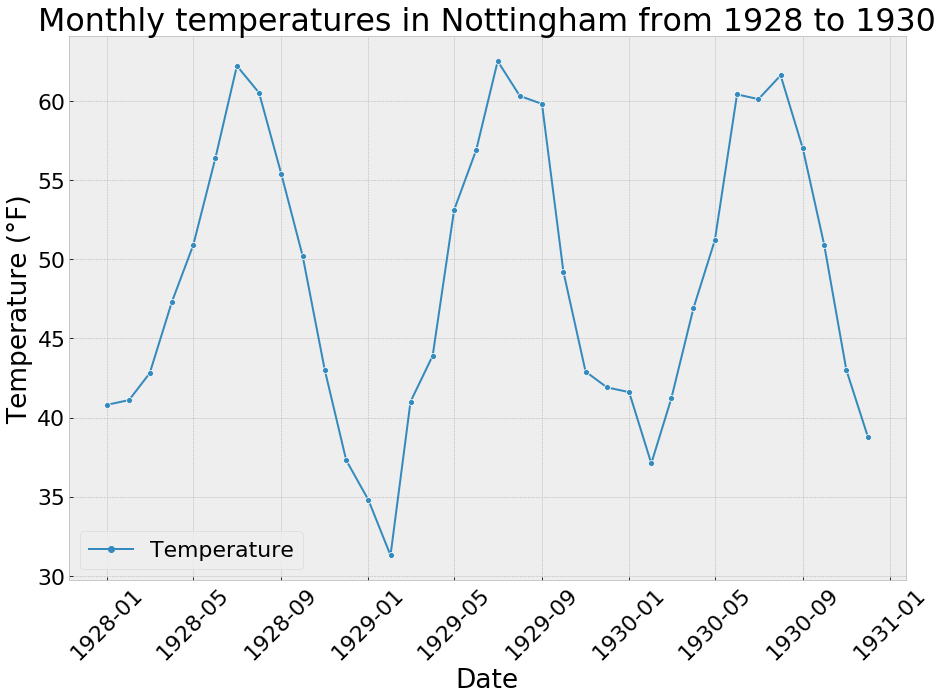

In [22]:
plt.ylabel('Temperature (°F)')
plt.xlabel('Time')
plt.xticks(rotation=45)
plt.title('Monthly temperatures in Nottingham from 1928 to 1930')
sns.lineplot(data = mean_monthly_temp['1928':'1930'], markers = True)

Of course the mean is lower during the Winter and greater during the Summer. No suprise here because we have this domain knowledge. We should see this monthly seasonality with a boxplot by month on the whole data set.

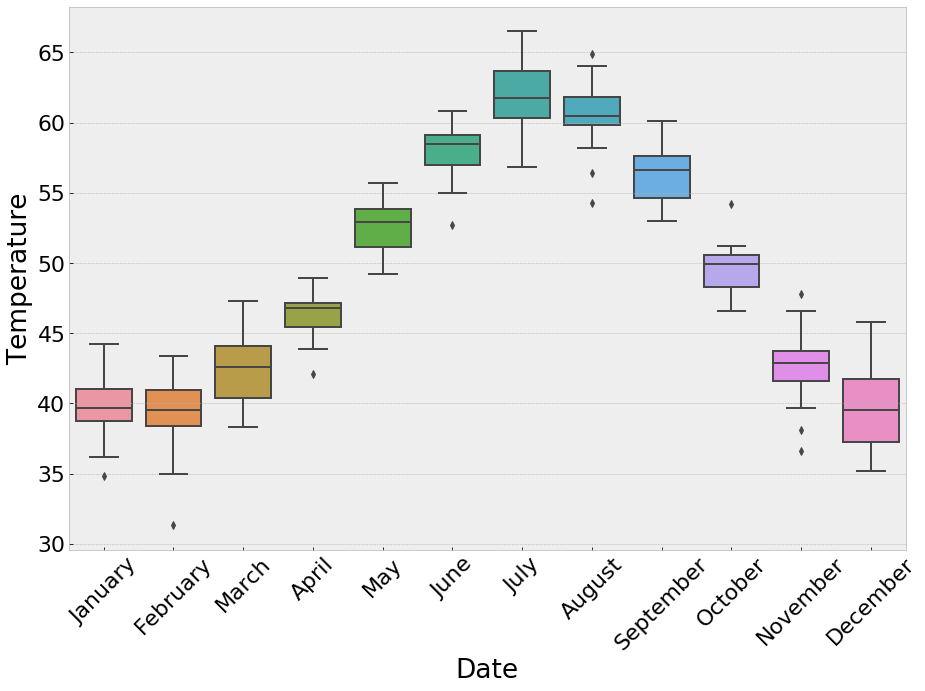

In [23]:
plt.xticks(rotation=45)
sns.boxplot(mean_monthly_temp.index.month_name(), mean_monthly_temp['Temperature'])

This boxplot is very instructive. We clearly see the monthly seasonality. July is the month with the highest median and December, January and February are the coldest months.

I think there is no clear trend. But to be sure we can use a convenient function from the statsmodel module.

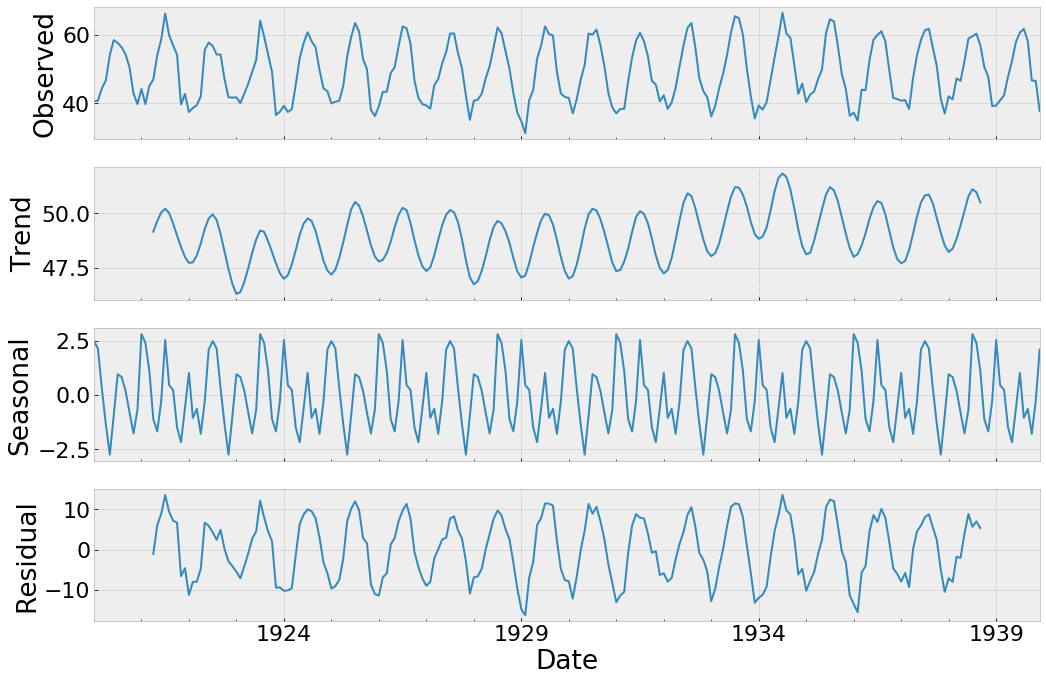

In [24]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig = seasonal_decompose(mean_monthly_temp, model='additive', freq=30).plot()

The seasonality is so strong that the trend evolves with the seasonality. We have what we call a stationary process. The rolling mean and variance are constant and the autocovariance does not depend on the time. We can verify by using the augmented Dickey-Fuller test. The implementation of the function is in a python module we created to use this function in several notebooks without having to copy/paste the same code each time we need to check for the stationarity of a process.

In [25]:
test_stationarity(mean_monthly_temp['Temperature'])

Test statistic: -3.255
p-value: 0.017
Number of lags used: 14
Critical value, 1 %: -3.460
Critical value, 5 %: -2.874


Please see the notebook time_series_forecasting for more info on the **Dickey-Fuller test**. From the values we got, we can conclude that the process is **stationary** with a **risk of 5 %**.

## Facebook prophet

### Context

**Facebook prophet** is a library available in **Python and R** dedicated to **time series forecasting**. As mentioned in the [original white paper](https://peerj.com/preprints/3190.pdf), this package is intended for analysts with **domain knowledge** but with no time series expertise. Indeed, time series forecasting is a hard task as it exists a large variety of different time series and techniques. There are only a few data scientists expert in this field and it is why Facebook open sourced Prophet, a framework that makes the life of data scientists/analysts easier. It provides **configurable models** and *anlyst-in-the-loop* **performance analysis**. It is espescially used for **supply-chain management**, **production** and **anomaly detection**.

Let's test it on our time series following the approach in the [quick start tutorial](https://facebook.github.io/prophet/docs/quick_start.html).

In [26]:
from fbprophet import Prophet

First we have to reformat our dataframe because Prophet expects a specific format.

In [27]:
mean_monthly_temp_prophet = mean_monthly_temp.reset_index()
mean_monthly_temp_prophet.columns = ['ds', 'y']
mean_monthly_temp_prophet.head()

,ds,y
0,1920-01-01,40.6
1,1920-02-01,40.8
2,1920-03-01,44.4
3,1920-04-01,46.7
4,1920-05-01,54.1


Then we can create the model. We leave the default parameters for now.

In [28]:
model = Prophet()
model.fit(mean_monthly_temp_prophet)

/anaconda3/envs/finance/lib/python3.6/site-packages/fbprophet/forecaster.py:880: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  min_dt = dt.iloc[dt.nonzero()[0]].min()
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/anaconda3/envs/finance/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


Predictions are made on a new dataframe. We can specify the number of predictions we want and the frequency. We have a value per month, I think we can predict the values of the next 6 months to get an idea.

In [29]:
future = model.make_future_dataframe(periods=6, freq='M')
predictions = model.predict(future)

In [30]:
predictions[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
241,1940-01-31,40.170690,37.494251,42.872444
242,1940-02-29,43.066030,39.930265,45.813928
243,1940-03-31,47.567471,44.793466,50.343386
244,1940-04-30,52.150199,49.344054,54.938488
245,1940-05-31,58.277546,55.513676,61.107372


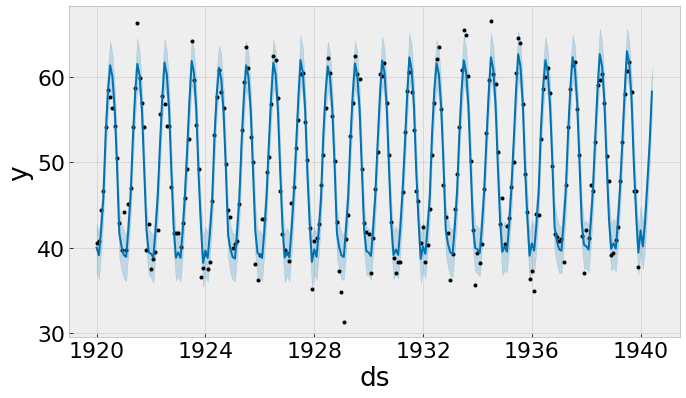

In [31]:
fig1 = model.plot(predictions)

Quite good for a quick start. We see that the model seems to fit well the previous data points and the predictions look good! But now we want a way to evaluate our model and have performance metrics.

### Evaluate a model with Facebook prophet

Now it's time to evaluate the performances of the model. To measure the quality of our model, we need to **split** the data set into a **training set** and a **test set**. The problem with time series is that we can't take a random sample of our data set as a test set. Indeed, contrary to Machine Learning problems, the variables are not **independent**, they depend on the time. So we'll split our data set into two parts:
* historical part, biggest part
* prediction part, most recent records

In [32]:
from fbprophet.diagnostics import cross_validation

Here we do cross-validation to assess prediction performance on a horizon of 180 days (6 months), starting with 2 years of training data in the first cutoff and then making predictions every 13 months.

In [33]:
df_cv = cross_validation(model, initial=f'{30*2*12} days' , period=f'{3*30} days', horizon=f'{6*30} days')
df_cv.head()

INFO:fbprophet:Making 71 forecasts with cutoffs between 1922-03-05 00:00:00 and 1939-06-04 00:00:00
INFO:fbprophet:n_changepoints greater than number of observations.Using 20.0.
INFO:fbprophet:n_changepoints greater than number of observations.Using 23.0.


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,1922-04-01,45.562519,43.969785,47.244556,42.1,1922-03-05
1,1922-05-01,51.063261,49.363718,52.905205,55.7,1922-03-05
2,1922-06-01,53.948987,52.160269,55.588097,57.8,1922-03-05
3,1922-07-01,62.548627,60.855484,64.254339,56.8,1922-03-05
4,1922-08-01,54.062916,52.356597,55.712135,54.3,1922-03-05


Then we can compute the performance metrics. Prophet provides us different metrics:
* Mean Squared Error (MSE): it measures the squares of the error (the difference between the actual value and the predicted value). It is always positive and the values closer to zero are better.
$$ MSE = \dfrac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}$$

* Root Mean Squared Error (RMSE): it is the square root of the MSE.
$$ RMSE = \sqrt{\dfrac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2}}$$

* Mean Absolute Error (MAE): it is also a comparison of the observed value vs the predicted value but this time we take the absolute value of the error instead of the squared difference. It is easier to interpret.

$$ MAE = \dfrac{1}{n} \sum_{i=1}^{n} |y_{i} - \hat{y}_{i}|$$

* Mean Absolute Percent Error (MAPE)

In [34]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p.sample(n=10)

,horizon,mse,rmse,mae,mape,coverage
12,61 days,5.800734,2.408471,1.941974,0.040639,0.785714
4,149 days,4.801532,2.191240,1.707317,0.036832,0.785714
171,35 days,6.694964,2.587463,2.043338,0.042213,0.666667
339,102 days,8.237734,2.870145,2.232654,0.049312,0.642857
0,27 days,6.913487,2.629351,2.164516,0.045959,0.714286
185,100 days,7.493786,2.737478,2.053563,0.046436,0.714286
209,105 days,8.094231,2.845036,2.197061,0.048505,0.666667
145,120 days,6.917096,2.630037,2.063831,0.042649,0.738095
11,30 days,6.185395,2.487046,2.025166,0.041983,0.714286
32,125 days,7.893619,2.809559,2.157528,0.044316,0.690476


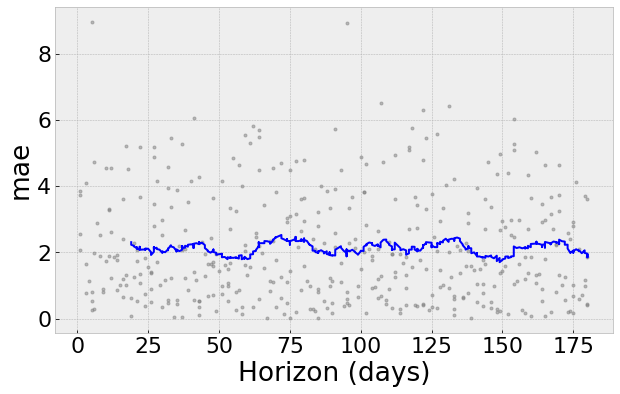

In [35]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mae')

It is interesting to notice that the MAE does not increase over the number of days of the horizon. It's good. Furthermore, the MAE is quite low, around 2 degrees, which is acceptable.

### Model used by Facebook

The model used by Facebook is easier to understand and to tune than an **ARIMA** or a **LSTM RNN**. However, for specific use cases, it performs well and sometimes even better than more complex models. It is an additive model and more precisely a [generalized additive model (GAM)](https://en.wikipedia.org/wiki/Generalized_additive_model).
Time for a little bit of maths! There are three main components and the model can be decomposed as follows:

$$y(t) = g(t) + s(t) + h(t) + \epsilon_{t}$$

* $g(t)$: **trend** function (non periodic changes)
* $s(t)$: **seasonality** function (periodic changes)
* $h(t)$: **holidays** function (irregular changes due to holidays)
* $\epsilon_{t}$: **error term**

So this model is basically a **regression** with only the time as a regressor. It presents some advantages as described in the [white paper](https://peerj.com/preprints/3190.pdf):
* flexibility (quickly adapts to new trends)
* the measurements do not need to be regularly spaced
* very fast
* easily interpretable

That's it for Facebook Prophet. It is definitely a tool I recommend for beginners with time series or people who don't have time to fine tune more complex models.

## ARIMA

I think ARIMA (Auto Regressive Integrated Moving Average) is the most famous tool for time series data. However, it is very complex to understand. So let's take a new example and see what we can do with this method.